# Do More with Twitter Data

Twitter is what's happening and what people are talking about right now, with hundreds of millions of Tweets sent each day. We're a group of data scientists on the Twitter Data team who are helping people do more with this vast amount of data in less time. In this spirit, we are starting a series of tutorials that aim to help people work with Twitter data effectively. Each of the posts in this series centers around a real-life example project and provides MIT-licensed code that you can use to bootstrap your projects with our enterprise and premium API products. We hope this series is fruitful for you and we are excited to see what you'll build.

## Data Collection, Filtering, and Parsing

- By Fiona Pigott,  @[notFromShrek][fiona], Data Scientist at Twitter, Jan 2018

In this inaugural post, we'll introduce data collection, filtering, parsing, and summarizing. We want to be able to give readers an easy way to spin up on the Twitter Search APIs, tips around quickly examining data, and guidelines around one of the most difficult and most overlooked Twitter data challenges: making sure you get the right Tweets for the job.


### *Caveat*

This post is not meant to be a tutorial in Python or the PyData ecosystem and assumes that readers have a reasonable amount of technical sophistication, such that they could find the right Tweets for their use case in any language or framework. This tutorial uses Python because our group makes heavy use of the PyData stack (python, pandas, numpy, etc.), but a technical user could follow along in a programming language of their choice.


[fiona]: https://twitter.com/notFromShrek "Twitter Profile"

## Using Twitter data to answer a question

Typically you will start with a very high-level question that requires refinement to understand what data might be useful to you in answering that question. For this post, let's start with a broad question:

"*_I want to understand airline customers while they fly._*"
    
We'll begin our refinement process from here.
 
## *Why* do we want to know this?

Understanding the business need behind a question is paramount. Use it to understand where it is important to spend extra time to be exact, and where an estimation will suffice. Also use "why" to understand when the analysis needs to be complete--the best analysis is not useful if it is finished a month after a decision is made and presented.

## *What* are we interested in?

Use this question to help define where to begin with the analysis and which data to pull. To understand airline customers' behavior while they are flying and getting ready to fly, we are interested in people actually in an airport or on a plane, but we are not interested in people simply talking about airlines (sharing news stories about an airline, for instance).
 
## *When* is this information relevant?

Deciding on a relevant timeframe is all about the business use case: if you're tracking a trend over a long period of time, you may need years of data; if you're looking at the audience of a single TV premier, a few days of data may be enough.

In the case of our air travel question, we're only interested in any given Twitter user in the few hours around their plane flight, so we don't necessarily need to track Tweets over a long period of time. We do, however, want to get enough of a sample to make generalizations about how people Tweet before and after flights, so we should make sure to collect enough data over a long enough period of time to examine multiple flights.

## *Who* are we interested in?

Using simple rule filters like country and language can go a long way towards helping us analyze Tweets from the right people. 
In this case, we're interested in people from all demographics, as long as they are *also* passengers on an airline. We can likely identify those people through their language ("About to take off, headed home to Boulder!"), their granular geo-tagged location, or Twitter place ("Denver International Airport").

 
## *Where* are they?
We can use Twitter's geo data and enrichments to make sure that our users are in relevant locations, if that is important to the question. Another way to approximate a user's location might be the language they speak, or even the time that they are Tweeting (if you're collecting Tweets at 2AM PST, don't expect to see a lot of content from California).
 
Remember, selecting only users for whom we have a very granular locations (like a geo-tag near an airport) means that we only get a sample of users. For studies where we want to know generally what people are talking about that might not be a problem, but it isn't as effective for studies where we want an exact count. Keep those trade-offs in mind when designing a data query.

---------------

Once we have a good understanding of our question, the next steps are to figure out how to get to the answer using Twitter data. We'll have to get the right data, understand it, and filter out any irrelevant data.

__Steps to get to an answer__  

1. Consume Tweet data 
    - We need to get Tweets to analyze them. We'll walk through using the Python client for the Twitter Search API right inside this notebook. All you need is an account.
2. Parse Twitter data
    - You can't analyze what you can't load. Understand the structure of the data, and get the pieces that are important to your analysis.
3. Describe Twitter data
     - Descriptive statistics go a long way. What are the most popular hashtags? When are people Tweeting about these topics? Where is noise coming from? Are there specific URLs, hashtags, or @-mentions being shared that *aren't* relevant to your analysis? 
4. Iterate on your search terms to filter the data
    - We can't simply ask for every Tweet. A thoughtful analysis needs to work within the bounds of the Twitter data APIs to filter and retrieve the right data for the job--and for your data budget. Now that you know how to quickly edit rules to retrieve small quantities of data, as well as parse and describe a set of Tweets, it's time to iterate on filters to retrieve the data that is relevant to your question (and not pay for data that isn't).


--------------- 


# 1. Consume Tweet data: the Twitter Search APIs

## Twitter Search APIs query language

In order to pull Tweets from the Search APIs, you will first have to understand how to write a search query in Twitter's premium / enterprise search API's query language. The most important basics are these:

- Operator: Anything that can select or "match" a Tweet. One type of operator is a simple token match. A token match operator is simply the word, e.g. `cat`, and matches when that word occurs within the text of the Tweet. Token matches always disregard case.
- Logical "and": words (tokens) joined by a `space` are treated as queries and-ed together. For instance, the query "`cat dog`" would search for Tweets with both `cat` and `dog` somewhere in the text of the Tweet.
- Logical "or": the operator "`OR`" (capitalization is important here) between two tokens means that your rule will match on either term (without needing both to be present). The rule "`cat OR dog`" will match on a Tweet with _either_ "`cat`" or "`dog`" in the Tweet text.
- Grouping: use parentheses `()` to group operators together. In the query-language order of operations, "and" (`_`) is applied before "or" (`OR`), so use parentheses to make your groups explicit. "`cat dog OR bunny`" is different from "`cat (dog OR bunny)`" (can you see why?).
- Negation: use the operator "`-`" to negate operators (such as terms that you definitely _don't_ want in your dataset). You might search for Tweets about cats and _not_ about dogs with this type of query "`cat -dog`".

Detailed information on operators can be found [here](https://developer.twitter.com/en/docs/tweets/search/guides/premium-operators). We'll introduce and use some more advanced operators later.

__Caveat__  
When using any rule operators, you need to be careful to understand which parts of a field a rule is matching on. On twitter.com a Tweet seems like a simple thing, but a [Twitter data payload](https://developer.twitter.com/en/docs/tweets/data-dictionary/overview/intro-to-tweet-json) can have more than 100 fields, and different operators match on different fields. For this reason, it's important to make sure that you read the documentation around each operator and test your rules to be sure that they are behaving as you expect.  
One example: "`cat`" (the token match operator) will only match text that the user typed out for that Tweet (it won't for instance, match the word "`cat`" in the users's name or bio).

## Consuming Tweets
In order to Search for Tweets, we're going to use Twitter's [enterprise-grade Twitter search tool](https://developer.twitter.com/en/docs/tweets/search/overview/full-archive-search). This tools allows a user to make a request for Tweets by specifying a rule (more on that in a minute) that matches some Tweets and retrieve results. This tutorial is also compatible with the 30-day search API, though you will have to change some of the dates for searching due to the 30-day historic limitation.


__Requesting some Tweets__  
In order to search for Tweets, we have to understand specifically how Twitter's search rules work. We'll outline a few simple rules, and we'll talk more about details later when we iterate on our rules.

 **Time window for search**   
   Look for Tweets within a certain time window by specifying the time window in minute granularity.

 **Search rules are simple, boolean, token matches**  
   Tweets are tokenized on spaces and punctuation, and those tokens are matched to a rule. Let's look at a simple example:  
   > **Tweet**: `"Boarding the plane to fly to Tokyo in a few hours! So excited!"`   
   > **Tokens** (capitalization is ignored): `"boarding", "the", "plane", "to", "fly", "to", "tokyo", "in", "a", "few", "hours", "so, "excited"`

A rule that collected this Tweet might have been `"plane"` (because the exact token `"plane"` is included in the token list). You should note that these matches rely on complete tokens: this Tweet would **not** match if our rule was `"airplane"`.    
   
 **You can search for more than one token in a rule**   
   A search for Tweets about flying on planes might include any Tweet with the word `"airplane"` *or* the word `"plane"` *or* the word `"flying"` to get all of the relevant Tweets. In a single rule, use the operator `OR` (capitalization is important here) to search for *any* of a set of keywords.   
   > `"airplane OR plane OR flying"`
   
 **You can combine criteria using *and* logic, and combine tokens into phrases using quotation marks**   
   Maybe you want the to find Tweet that include the word `"flying"` and the word `"plane"` but only when they appear together. Here, you would want to use Boolean `AND` logic to combine tokens into a single rule. In the syntax of Twitter's Search API, `AND` is simply represented by a space.
   > **rule**: `flying plane`  
   > **match**: `"I'm flying in a plane!"`  
   > **no match**: `"I'm flying!"` or `"I'm in a plane!"`
   
   You can also look for specific phrases (combinations of tokens) using quotation marks. Use `"` to combine tokens and look for them in a specific phrase.
   > **rule**: `"air travel"`  
   > **match**: `"Air travel is great"`  
   > **no match**: `"Travel by air is great"` or `"Traveling in an airplane"`

 **You can exclude certain tokens that are irrelevant to your analysis**    
  Keep in mind that tokens do not exactly map to meaning (especially on a colloquial platform like Twitter). If you are looking for Tweets about flying (on an airplane), and you submit the rule `"flying"`, `"I don't give a flying f**k what you do."` would match your rule (true story: I've had to exclude the phrase `"flying f**k"` from this analysis 😳).   
  Use a "`-`" to exclude, and use parentheses to group together logical clauses:
  > `"(airplane OR plane OR flying) -fuck"`   

This isn't a comprehensive guide, and more clarification can be found in our [documentation](http://support.gnip.com/apis/search_api2.0/rules.html).


__Getting the results__  
Twitter's Search APIs return results in *pages*, with up to 500 Tweets per page for paid tiers. For users in a sandbox environment, you can receive a maximum of 100 Tweets per call. For a very low-volume search, you might only need one page to retrieve all of the results. For a high-volume search, you can choose to make multiple API call to receive multiple pages of results.

__Python client__  
Consuming data from Twitter APIs directly into an environment where we can analyze them is important for fast iteration on queries. The data science team has created some Python libraries that make it easy to consume data from Twitter's Search APIs directly into this notebook.

This package can be found at https://github.com/twitterdev/search-tweets-python and implements a Python wrapper to:
  - Create appropriately formatted rule payloads (date and rule query parameters)
  - Make requests of the API
  - Gracefully handle pagination of Search APIs results (be aware--the tool can make multiple API calls, so but sure to set the `max_tweets` parameter, which we'll point out)
  - Load the resultant Tweet text data as Python objects

## Running This Notebook

If you want to run this notebook, it is hosted [here](https://github.com/twitterdev/do_more_with_twitter_data). Clone this repo and you'll see this notebook in the `examples/finding_the_right_data` directory.
Please see the accompanying `README.md` file for full instructions. We've provided both a pip-ready `finding_the_right_data_requirements.txt` file and a conda environment file, `finding_the_right_data_conda_env.yml` that allows an easy virtual environment for this example. This example assumes Python 3.6.



__Credentials__  

Please go ahead and make a YAML file named `.twitter_keys.yaml` in your home directory. 


For premium customers, the simplest credential file should look like this:

```yaml

search_tweets_api:
  account_type: premium
  endpoint: <FULL_URL_OF_ENDPOINT>
  consumer_key: <CONSUMER_KEY>
  consumer_secret: <CONSUMER_SECRET>
```

For enterprise customers, the simplest credential file should look like this:

```yaml

search_tweets_api:
  account_type: enterprise
  endpoint: <FULL_URL_OF_ENDPOINT>
  username: <USERNAME>
  password: <PW>
```


The rest of the example will assume `~/.twitter_keys.yaml` exists, though you can specify your connection information directing in the notebook or using an environment variable if you want. For more information, please see the `searchtweets` [section on credential handling](https://twitterdev.github.io/search-tweets-python/#credential-handling).


The `load_credentials` function parses this file and we'll save the `search_args` variable for use throughout the session.

In [1]:
from tweet_parser.tweet import Tweet
from searchtweets import (ResultStream,
                           collect_results,
                           gen_rule_payload,
                           load_credentials)

search_args = load_credentials(filename="~/.twitter_keys.yaml",
                               account_type="enterprise")

In the following cells, we'll define our rule and rule payloads, then use the `collect_results` method to get our tweets.

First - it is often convenient to assign a rule to a variable. Rules are strings and can be simple strings, e.g., `"(flying OR plane)"` or be literal blocks, which can be easier to read for long rules: 

```
"""
(flying 
 OR plane
 OR landed)
"""
```

The remaining functions will parse newlines correctly.

Below, we'll start with a simple rule.

In [2]:
_rule_a = "(flying OR plane OR landed OR airport OR takeoff)"

The function, `gen_rule_payload`, will generate the JSON used to make requests to the search endpoint. Its full API doc lives [here](https://twitterdev.github.io/twitter_search_api/twittersearch.html#twittersearch.api_utils.gen_rule_payload), but it has several main parameters:

1. `pt_rule` (or the first positional arg) – The string version of a powertrack rule
2. `results_per_call` – number of tweets or counts returned per API. Defaults to 500 to reduce API call usage, but you can change it as needed. It can range from 100-500.
3. `from_date` – Date the starting time of your search.
4. `to_date` – Date  for the end time of your search.
5. `count_bucket` – If using the counts api endpoint, this will define the count bucket for which tweets are aggregated. This must be set if you want to use the Counts API.


The time searches can be specified via the following dates or datetimes, down to minutes, e.g.:

- `2017-12-31`
- `2017-12-31 23:50`
- `2017-12-31T23:50`
- `201712312350`

Specifying a date will return a date starting at 00:00. 

The `from_date` and `to_date` parameters are optional. The search API defaults to returning up to the last 30 day's worth of tweets.

In [3]:
rule_a = gen_rule_payload(_rule_a,
                        from_date="2017-07-01",
                        to_date="2017-08-01",
                        results_per_call=500)

rule_a

'{"query":"(flying OR plane OR landed OR airport OR takeoff)","maxResults":500,"toDate":"201708010000","fromDate":"201707010000"}'

The `collect_results` function is the fastest entry point to getting Tweets. It has several parameters:

- `rule`: a valid payload made from `gen_rule_payload`
- `max_results`: the maximum number of Tweets or counts you want to receive
- `result_stream_args`: the search arguments and authentication info for this request.

And it returns a list of results, Tweets or counts.

In [4]:
results_list = collect_results(rule_a, 
                               max_results=500, 
                               result_stream_args=search_args)

In [5]:
# hark, a Tweet!
results_list[0]

{'contributors': None,
 'coordinates': None,
 'created_at': 'Mon Jul 31 23:59:59 +0000 2017',
 'entities': {'hashtags': [{'indices': [43, 50], 'text': 'defcon'}],
  'symbols': [],
  'urls': [],
  'user_mentions': []},
 'favorite_count': 0,
 'favorited': False,
 'filter_level': 'low',
 'geo': None,
 'id': 892173026116202498,
 'id_str': '892173026116202498',
 'in_reply_to_screen_name': None,
 'in_reply_to_status_id': None,
 'in_reply_to_status_id_str': None,
 'in_reply_to_user_id': None,
 'in_reply_to_user_id_str': None,
 'is_quote_status': False,
 'lang': 'en',
 'matching_rules': [{'tag': None}],
 'place': None,
 'quote_count': 0,
 'reply_count': 0,
 'retweet_count': 0,
 'retweeted': False,
 'source': '<a href="http://tapbots.com/tweetbot" rel="nofollow">Tweetbot for iΟS</a>',
 'text': 'Left for airport at 4:45AM, pleased to see #defcon hackers still partying at Caesars bars. Not pleased to be heading to airport at 4:45AM.',
 'truncated': False,
 'user': {'contributors_enabled': False,


## 2. Parse Twitter data

Let's take the 1st Tweet from our results list and discuss its various elements.

Tweet data is returned from the API as a single JSON payload with a `results` array, containing many JSON Tweet payloads. The `searchtweets` package parses that data for you (including abstracting away concerns about the specific format of the Tweet payloads) using our [`tweet_parser`](https://github.com/tw-ddis/tweet_parser) package and handles any errors caused by non-Tweet messages (like logging messages), returning `Tweet` objects (I'll explain about that in a second). 


To better understand Tweets, you should check out [our developer website](https://developer.twitter.com/en/docs/tweets/data-dictionary/overview/intro-to-tweet-json ) for information on Tweet payload elements. For now, I'm going to explain a few key elements of a Tweet and how to access them.

## The nitty gritty: Tweet payloads

We'll grab a single example Tweet: just the first one from our list.
This is a Tweet object, which has all of the properties of a Python `dict` as well as some special, Tweet-specific attributes.

In [6]:
example_tweet = results_list[0]
example_tweet["id"]

892173026116202498

**A note on Tweet formatting and payload element naming**  

It just so happens that the format of this Tweet is "original format," so we can look up the keys
(names of payload elements) on our support website. 
It's possible (but unlikely) that your Search API stream is configured slightly differently, and you're looking at "activity streams" formatted Tweets (if so, this is completely fine). We'll add the equivalent "activity streams" keys in the comments.

You can look up specific of Tweet payload elements [here](https://developer.twitter.com/en/docs/tweets/data-dictionary/overview/tweet-object).

Note that the `tweet_parser` package will abstract away the format of the Tweet, and either activity streams or original format will work fine in this notebook.

**Now, the text of a Tweet:**

The text of the Tweet (the thing you type, the characters that display in the Tweet) is stored as a top-level key called "text."

In [7]:
print(results_list[0]["text"])

# uncomment the following if you appear to have an activity-stream formatted Tweet
# (the names of the payload elements are different, the data is the same):
# results_list[0]["body"]

Left for airport at 4:45AM, pleased to see #defcon hackers still partying at Caesars bars. Not pleased to be heading to airport at 4:45AM.


**Other Tweet elements**  
Be sure to read the documentation, we cannot enumerate every Tweet element here. Note that certain fundamental and useful Tweet elements are extracted for you, such as a #hashtag or an @mention.

You can access, for instance, a Tweet's #hashtags like this:

In [8]:
results_list[0]["entities"]["hashtags"]

# uncomment the following if you appear to have an activity-stream formatted Tweet
# results_list[0]["twitter_entities"]["hashtags"]

[{'indices': [43, 50], 'text': 'defcon'}]

In [9]:
# in case that first Tweet didn't actually have any hashtags:
[x["entities"]["hashtags"] for x in results_list[0:10]]

# uncomment the following if you appear to have an activity-stream formatted Tweet
# [x["twitter_entities"]["hashtags"] for x in results_list[0:10]]

[[{'indices': [43, 50], 'text': 'defcon'}],
 [],
 [{'indices': [22, 30], 'text': 'Algerie'}],
 [],
 [],
 [{'indices': [1, 5], 'text': 'New'}],
 [],
 [],
 [],
 []]

## tweet_parser

You will always need to understand Tweet payloads to work with Tweets, but a Python package from this team (`pip install tweet_parser`) attempts to remove some of the hassle of accessing elements of a Tweet. This package works seamlessly with both possible Twitter data formats, and supplies the `Tweet` object we referred to earlier.

Before doing a lot of work with this package (but not right this minute!), we would encourage you to read the documentation for the `tweet_parser` package at https://twitterdev.github.io/tweet_parser/. The package is open-source and available on GitHub at https://github.com/twitterdev/tweet_parser. Feel free to submit issues or make pull requests.

The `Tweet` object has properties that allow you to access useful elements of a Tweet without dealing with its format. For instance, we can access some of the text fields of a Tweet with:

In [10]:
print("Literally the content of the 'text' field: \n{}\n" .format(results_list[0].text))
print("Other fields, like the content of a quoted tweet or the options of a poll: {}, {}".format(
    results_list[0].quoted_tweet.text if results_list[0].quoted_tweet else None,
    results_list[0].poll_options))

Literally the content of the 'text' field: 
Left for airport at 4:45AM, pleased to see #defcon hackers still partying at Caesars bars. Not pleased to be heading to airport at 4:45AM.

Other fields, like the content of a quoted tweet or the options of a poll: None, []


As the Twitter platform changes, so do the fields in the data payload. For instance, "extended" and "truncated" tweets have been introduced to stop 280 character from causing breaking changes. The `Tweet` object has a convenience property `.all_text` that gets "all" the text that a Tweet displays.

In [11]:
results_list[0].all_text

'Left for airport at 4:45AM, pleased to see #defcon hackers still partying at Caesars bars. Not pleased to be heading to airport at 4:45AM.'

We cannot dive into detail on every property of `Tweet` that we'll use in this notebook, but hopefully you get the idea. When we call `.something` on a `Tweet`, that `.something` is provided in the `tweet_parser` package and documented there.  

For now, we will describe the elements of the payload that we'll use in this analysis.

- **time**: The time that a Tweet was created. This is always reported in UTC in the Tweet payload, and you can look for the user's timezone in the "user" portion of a Tweet payload if you want to translate this time to the user's time-of-day. A string of time information can be found in the `created_at` element of a Tweet, but since we're using the `tweet_parser` package, we can access a Python datetime object with `tweet.created_at_datetime` or an integer representing seconds since Jan 1, 1970 with `tweet.created_at_seconds`.
- **user**: The user who created the Tweet. The "user" portion of a Tweet payload contains many valuable elements, including the user's id (`tweet["user"]["id"]`, or `tweet.user_id` with the `tweet_parser` package), the user's screen name (`tweet.screen_name`, keep in mind that the user name may change), the user's timezone, potentially their derived location, their bio (a user-entered description at, `tweet.bio`) and more.
- **text**: The text of the Tweet. As Tweets get more complex (Retweets, Quote Tweets, poll Tweets, Tweets with hidden @-mentions and links), the text that you read in a Tweet can appear in many different areas of a Tweet payload. Here using the `tweet_parser`-provided attribute `tweet.all_text`, which aggregates all of the possible text fields of a Tweet (the quoted text, the poll text, the hidden @-mentions, etc) into one string.
- **hashtags**: Tweet payloads contain a field that list hashtags present in the Tweet (you do not have to parse them out yourself). The `tweet_parser` Tweet attribute `tweet.hashtags` provides a list of hashtags.
- **mentions**: You don't have to parse out @-mentions yourself either. Use `tweet.user_mentions` for a list of users (names and ids) mentioned in a Tweet.
- **URLs**: Many Tweet contain links to outside sources, articles or media. You can pull the literal link text from a Tweet, or use Twitter's URL enrichments (if you've purchased them) to unroll URLs and get insight into the linked content.
- **geo**: For the small sample of Tweets where explicit lat/lon geo data is available, use `tweet.geo_coordinates` to get locations.

Now we can take all of those aforementioned elements, parse them out of my Tweets, and put them in a [Pandas](https://pandas.pydata.org/pandas-docs/stable/) [Dataframe](https://pandas.pydata.org/pandas-docs/stable/dsintro.html#dataframe).

In [12]:
import pandas as pd

# make a pandas dataframe
data_df = pd.DataFrame([{"date": x.created_at_datetime,
                         "text": x.all_text,
                         "user": x.screen_name,
                         "bio": x.bio,
                         "at_mentions": [u["screen_name"] for u in x.user_mentions],
                         "hashtags": x.hashtags,
                         "urls": x.most_unrolled_urls,
                         "geo": x.geo_coordinates,
                         "type": x.tweet_type,
                         "id": x.id} for x in results_list]).set_index("date")

## Before you read these Tweets

You're going to look at this Tweet data and you (should) feel a little sad. We did all that work talking about rules, you've heard so much about Twitter data, and these Tweets mostly don't seem relevant to our usecase at all. They're not from our target audience (people flying on planes) and they're not even necessarily about plane trips. What gives?

There's a reason we started out with only one API call: we didn't want to waste calls pulling Tweets using an unrefined ruleset. This notebook is going to be about making better decisions about rules, iterating, and refining them until you get the Tweets that you want. And those Tweets are out there - there are, after all, *lots* of Tweets.

In [13]:
# data, parsed out and ready to analyze
data_df.head()

,at_mentions,bio,geo,hashtags,id,text,type,urls,user
date,,,,,,,,,
2017-07-31 23:59:59,[],davrik,None,[defcon],892173026116202498,"Left for airport at 4:45AM, pleased to see #de...",tweet,[],0davrik
2017-07-31 23:59:58,[God1stAmerica2d],Proudly Politically Incorrect. Widow of US Mar...,None,[],892173019040202752,Why is this even a question. ID needed for lic...,retweet,[https://twitter.com/i/web/status/892144209418...,AliasHere
2017-07-31 23:59:57,[LPLdirect],🇬🇳🇺🇸,None,[Algerie],892173017186435073,🔴INFOS #Algerie\n\nDeux pilotes d' Air Algérie...,retweet,[https://twitter.com/i/web/status/892152194920...,Wyzzyddl
2017-07-31 23:59:57,[Simbaki_],🏳️‍🌈 sc : kailabrielleeee / match ?,None,[],892173016372838400,We are unappreciative... we don't deserve Take...,retweet,[],KailaBrielleee_
2017-07-31 23:59:56,[realDonaldTrump],Consultant • 💻 Network Engineer • brunch advoc...,None,[],892173013625573376,@realDonaldTrump Watch Trump get lost going fr...,quote,[https://twitter.com/i/web/status/892173013625...,LoveRunandPray


## 3. Describe your data

Descriptive statistics can tell you a lot about your dataset with very little special effort and customization. Having a good set of descriptive statistics coded up that you always run on a new dataset can be helpful. Our team maintains [Gnip-Tweet-Evaluation](https://github.com/tw-ddis/Gnip-Tweet-Evaluation) a repository on GitHub that contains some tools to do quick evaluation of a Tweet corpus (that package is useful as a command line tool, and as a template for Tweet evaluation).

I'm going to walk through a few different statistics that might help us understand the data better:
- **What is generating the Tweets?**: One statistic that is common and useful in understanding a group of Tweets is understanding how many of them are Retweets or Quote Tweets. Another interesting data point can be looking at the application that created the Tweet itself. 
- **Common words**: What are the most common words in the corpus? Are they what we expected? Are they relevant to the topic of interest?
- **Who is Tweeting**: Who are the users who Tweet the most? Are there spammy users that should be removed? Are they important users that we need to pay attention to?
- **Where are they Tweeting from**: What's the distribution of Tweet locations? Is that surprising?
- **Time series**: Are there spikes in the Tweet volume? When do they occur? What drives the spikes? For the sake of filtering out noise (or news stories that we don't care about) it may be important to identify spikes and filter out the Tweets that drive those spikes.

In [14]:
# plotting library
import matplotlib.pyplot as plt
# pretty plots
plt.style.use("bmh")
# better sizing for the notebook
plt.rcParams['figure.figsize'] = (10, 5)
%matplotlib inline

## How are people Tweeting?

Briefly, let's note that there are several different Twitter platform actions that can create a Tweet. 
- **original Tweet**: the user created a Tweet by typing it into the Tweet create box or otherwise hitting the `statuses/update` endpoint
- **Retweet**: the user reposted the Tweet to their own timeline, without adding and comment
- **Quote Tweet**: user added commentary to a reposted Tweet, essentially a Tweet with another Tweet embedded in it

This is sometimes an important distinction: how much do Retweets or Quote Tweets represent the experience of the user reposting? Do we actually want Retweets in our particular dataset? Are they likely to tell us anything about users who are actually traveling (put it this way: if a user Retweets a story about being at an airport, how likely does it seem that they are at an airport)?

In [15]:
data_df[["type","id"]].groupby("type").count()

,id
type,
quote,16
retweet,298
tweet,186


## Common words

Definitions:
- **corpus**: A collection of all of the documents that we are analyzing.
- **document**: A single piece of writing, in our case, a single Tweet
- **token**: Some characters from a document. Ideally, tokens would be common enough to occur in many documents, and have some semantic meaning--they provide us with a way to infer semantic correlation across documents.
- **stop word**: A stop word (something like "and","but","the") is a very common word with little semantic meaning, and we often exclude these words from word counts or NLP models.

__Tokenization__  
In order to count common terms, first we have to define our terms. The easiest thing for me to count is a token--a single unit of characters in a Tweet. Often we try to define tokens so that a token is basically a word. 


I'm going to tokenize the Tweets (split each Tweet into a list of tokens) using the [nltk TweetTokenizer](http://www.nltk.org/api/nltk.tokenize.html#module-nltk.tokenize.casual), which splits on spaces and throws away some punctuation. We will also throw away any tokens that contain no letters, and throw away any tokens that are less than 3 characters long. These choices--how to define a token, and which tokens to count, are somewhat arbitrary, but depend greatly on how language is used in the dataset. For instance, many tokenizers would remove the symbols "@" and "#" as punctuation, but on Twitter, those symbols mean something ("@Jack" is potentially very different from "jack"), and should perhaps be preserved.

In [16]:
from nltk.tokenize import TweetTokenizer
from nltk.stem.porter import PorterStemmer

def tweet_tokenizer(verbatim):
    try:
        tokenizer = TweetTokenizer()
        all_tokens = tokenizer.tokenize(verbatim.lower())
        # this line filters out all tokens that are entirely non-alphabetic characters
        filtered_tokens = [t for t in all_tokens if t.islower()]
        # filter out all tokens that are <=2 chars
        filtered_tokens = [x for x in filtered_tokens if len(x)>2]
    except IndexError:
        filtered_tokens = []
    return(filtered_tokens)

__Counting__  

Of course, we could simply create a dictionary of tokens in our corpus and iterate through the entire corpus of Tweets and adding "1" to a count every time we encounter a certain token, but it's more convenient to start using the scikit-learn API now and put our token counts into a format that's easy to use later. If you're unfamiliar with scikit-learn, it is an excellent Python machine learning framework that implements many common ML algorithms in a common building-block-able API.

I am going to use [scikit-learn's CountVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) to count tokens and turn the corpus into a document-term matrix. This makes it easy to count token frequencies. Note that the CountVectorizer allows us to count not only terms ("tokens") but n-grams (collections of tokens). For instance, if "plane" and "trip" are both tokens split on spaces, then explicit phrase "plane trip" might be a 2-gram in our corpus.

In [17]:
# get the most common words in Tweets
from sklearn.feature_extraction.text import CountVectorizer

def get_frequent_terms(text_series, stop_words = None, ngram_range = (1,2)):
    '''
    Input: 
       text_series: a list or series of documents
       stop_words: a list of stop_words to ignore, or the string 'english', 
                   which uses a built-in stop word list for the english language.
                   By default, there are no stop words used
       ngram_range: a single int, or a 2 tuple representing the range of ngrams to count.
                    the default (1,2) counts 1- and 2- grams.
    Returns:
       a dataframe of counts, indexed by n-gram
    '''
    count_vectorizer = CountVectorizer(analyzer = "word",
                                       tokenizer = tweet_tokenizer,
                                       stop_words = stop_words, # try changing the stopword sets that we use.
                                                                # notice that many top terms are words like 
                                                                # "and" and "the"
                                       ngram_range = ngram_range # you can change this to count frequencies of 
                                                           # ngrams as well as single tokens
                                                           # a range of (1,2) counts 1-grams (single tokens) and
                                                           # 2-grams (2-token phrases)
                                      )
    term_freq_matrix = count_vectorizer.fit_transform(text_series)
    terms = count_vectorizer.get_feature_names()
    term_frequencies = term_freq_matrix.sum(axis = 0).tolist()[0]

    term_freq_df = (pd.DataFrame(list(zip(terms, term_frequencies)), columns = ["token","count"])
                    .set_index("token")
                    .sort_values("count",ascending = False))
    return term_freq_df

In [18]:
term_freq_df = get_frequent_terms(data_df["text"], 
                                  stop_words = "english") # stop_words = "english" removes words like 'and'

In [19]:
term_freq_df.head(20)

,count
token,
airport,196
flying,123
plane,94
landed,48
home,31
trump,30
today,29
harry,27
just,27


In [20]:
term_freq_df.tail(10)

,count
token,
flying broom,1
flying bullets,1
flying california,1
flying car,1
flying cases,1
flying centre,1
flying chalice,1
flying check,1
flying close,1


__Hand labeling__  

Never underestimate the value of reading through your data. Actually look at the terms in the Tweets. Identify the Tweets that look like ones you are actually interested in.

Consider doing something like searching for specific, relevant, phrases that you hope will show up in your data:

In [21]:
data_df[data_df['text'].str.contains('flying home')]

,at_mentions,bio,geo,hashtags,id,text,type,urls,user
date,,,,,,,,,
2017-07-31 23:58:33,[WilkinsHarley],None,None,[],892172664948871168,@WilkinsHarley We would love too! Unfortunatel...,tweet,[],ChrisLeFrenchy


Or simply reading a few random Tweets in your data.

In [22]:
pd.set_option('display.max_colwidth', -1)
data_df[['text']].sample(5)

,text
date,
2017-07-31 23:59:29,"@IFLYGLACIER I never complain about things like this, but Kalispell Airport security's reckless negligence was unacceptable and harmful behavior today."
2017-07-31 23:58:08,Gostei de um vídeo @YouTube https://t.co/4VXfrqw4yg Plane
2017-07-31 23:57:31,a whole 9 second of jeongyeon taking care of tzuyu's skirt from flying 😭💛 https://t.co/lSDVZYWfrR
2017-07-31 23:59:34,🔴INFOS #Algerie\n\nDeux pilotes d' Air Algérie sont suspendu pour avoir laisser un enfant manipuler un avion en vol https://t.co/wh8Fmk71MX https://t.co/KHSz2nkvSs
2017-07-31 23:57:04,RT: This is why I'm jumping out of a plane on 18/08 to raise funds to help @LIONAID #SaveLions. Please sponsor me at https://t.co/6GY8WSmEkz https://t.co/U27B8YEofX


A subsequent post will cover unsupervised clustering, which can help you group together Tweets to more easily make sense of them (you might group Tweets into 10 groups, and read a few Tweets from each group).

## Who is Tweeting? Who is speaking?

I'm going to use some Pandas tricks (`.groupby` and `.agg`) to find the most commonly Tweeting users in the dataset.

In [23]:
(data_df[["user","bio","geo","id"]]
    .groupby("user") 
    .agg({"id":"count","bio":"first","geo":"first"}) 
    .sort_values("id",ascending = False)
    .rename(columns={'id':'tweet_count'})
).head(15)    

,tweet_count,bio,geo
user,,,
babyieturtle,6,ELF | YG/Rapper🌸,NaN
P3air,3,"Worldwide insurance approved King Air Flight School and Turbo-Prop flight training (inflight and simulator) for initial, recurrent and transition pilots.",NaN
CollectedN,2,"Various News, Videos, Opinions.",NaN
BloggerMe3,2,@Steveirons edits a blog site interested in the future shape of Australia. Get involved. Make a blog. Visit your hometown. http://www.pinterest.com/bloggerme,NaN
Moya_Monia,2,"""If you can do what you do best and be happy, you're further along in life than most people.""",NaN
RPMSports18,2,"24. University of South Alabama Alum. Just living life in a city below sea level. If you're reading this, then I probably popped up on your timeline.",NaN
heskiwi94x,2,An adult fangirl &attended too many concerts. #OneDirection #Belieber #Mixer #Arianator #Lovatic #The1975 #Sheerio etc. #WWATourPhilly #OTRAPhilly. I met 1/4,NaN
___13Dec,2,⠀⠀⠀⠀ ⠀⠀⠀⠀ ⠀⠀⠀⠀⠀⠀⠀⠀ ♡ ⠀⠀⠀⠀ ⠀⠀⠀⠀ ⠀⠀⠀ ⠀⠀⠀⠀ ⠀⠀⠀⠀TS. H. The1975 Kodaline Coldplay LANY OW⠀ ⠀⠀⠀ Linkinpark Troye Sivan Singto&Krist. PERAYA.⠀⠀⠀ ⠀⠀⠀⠀ ⠀⠀⠀⠀,NaN
billsplacehere,2,NaN,NaN


## Time series plot

Doing time-series analysis with Twitter data will be covered in depth in a subsequent post, but it's worth introducing here.
Another great way to get a broader picture of our data is to understand when people are Tweeting about these keywords. Now, recall that earlier we only grabbed a tiny sample of data, so those Tweets only cover a few minutes of activity--not a good way to build a time series. If you have access to the enterprise level API, you will be able to make an API call to the [counts endpoint](https://developer.twitter.com/en/docs/tweets/search/overview/enterprise) to retrieve a time series *without* needing to use many calls to retrieve all Tweets over a time period. Let's try it out.

__Counts endpoint__   

The counts endpoint has exactly the same API as the search endpoint, but instead of returning Tweets, it returns counts of Tweets. This is especially useful when you want to quickly assess a large dataset without retrieving a lot of data.

In [24]:
# use the same "_rule" string
print("Recall, our rule is: {}".format(_rule_a))
count_rule_a = gen_rule_payload(_rule_a,
                        from_date="2017-07-01",
                        to_date="2017-08-01",
                        results_per_call=500, 
                        count_bucket="hour")

counts_list = collect_results(count_rule_a, max_results=24*31, result_stream_args=search_args)

Recall, our rule is: (flying OR plane OR landed OR airport OR takeoff)


The resulting counts payload is a list of counts and UTC timestamps.

In [25]:
counts_list[0:5]

[{'count': 9018, 'timePeriod': '201707312300'},
 {'count': 9900, 'timePeriod': '201707312200'},
 {'count': 9251, 'timePeriod': '201707312100'},
 {'count': 9829, 'timePeriod': '201707312000'},
 {'count': 9315, 'timePeriod': '201707311900'}]

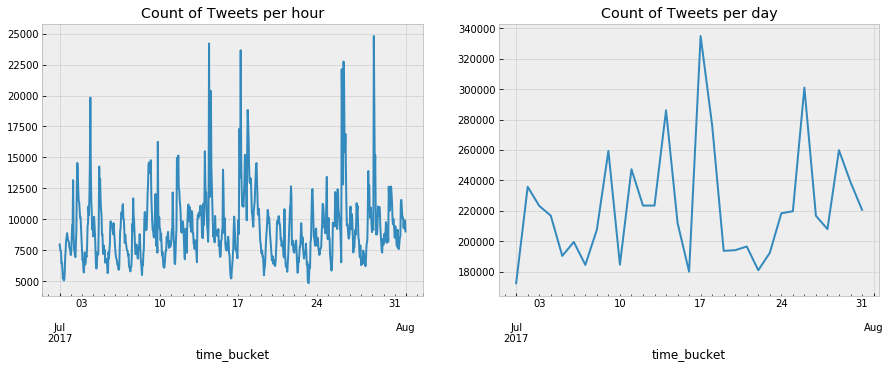

In [26]:
# plot a timeseries of the Tweet counts
tweet_counts_original = (pd.DataFrame(counts_list)
     .assign(time_bucket = lambda x: pd.to_datetime(x["timePeriod"]))
     .drop("timePeriod",axis = 1)
     .set_index("time_bucket")
     .sort_index()
)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize = (15,5))
(tweet_counts_original
 .plot(ax=axes[0],
       title = "Count of Tweets per hour",
       legend = False));
(tweet_counts_original
 .resample("D")
 .sum()
 .plot(ax=axes[1],
       title="Count of Tweets per day",
       legend=False));

__How can we use this information to understand our search data?__  

Consider the type of Tweets that we are looking for: we're looking for Tweets from people who are talking about air travel, hopefully people talking about their own experiences using air travel. It's pretty likely that air travel has a relatively regular pattern, with probably some big seasonal fluctuations (Thanksgiving?) and some daily fluctuations (people fly, for the most part during the day); it's unlikely that 2 or 3 times as many people fly on any given Monday vs the Mondays around it.

We can use an intuition about what spikes mean in our data to either filter out high volume noise, or, in the case where spikes are what we are seeking out (say we wanted the audience for a movie release that happens on a specific day), zooming in on important time periods.

Let's choose a few large spikes in this data and investigate further, then exclude that topic from our final Twitter dataset.


__Note:__  
If you don't have access to the counts API, you should still take a few small, time-boxed samples of data across the entire period of interest and doing the same exercise. It's harder to specifically target spikes, but it will help you get a broader sample of data.

In [27]:
# you can look at the plots to get a sense of what the highest-volume time periods are, or just sort your dataframe
(tweet_counts_original
 .resample("D")
 .sum()
 .sort_values(by = "count", ascending = False)
 .head())

,count
time_bucket,
2017-07-17,334922
2017-07-26,301029
2017-07-14,286049
2017-07-18,276175
2017-07-29,259820


In [28]:
# let's look at the highest volume day
spike_rule_717 = gen_rule_payload(_rule_a,
                              from_date="2017-07-17",
                              to_date="2017-07-18",
                              results_per_call=500)

spike_results_list_717 = collect_results(spike_rule_717, max_results=500, result_stream_args=search_args)

In [29]:
# what are these Tweets about?
get_frequent_terms([x.all_text for x in spike_results_list_717],
                   stop_words = "english").head(20)

,count
token,
got,459
flying,273
security,228
instead,227
flying cars,225
cars,225
office,224
robot drowned,223
got suicidal,223


In [30]:
# It's sometimes important to get the context of a full Tweet
[x.all_text for x in spike_results_list_717 if "drowned" in x.all_text.lower()][0:10]

['Our D.C. office building got a security robot. It drowned itself.\n\nWe were promised flying cars, instead we got suicidal robots. https://t.co/rGLTAWZMjn',
 'Our D.C. office building got a security robot. It drowned itself.\n\nWe were promised flying cars, instead we got suicidal robots. https://t.co/rGLTAWZMjn',
 'Our D.C. office building got a security robot. It drowned itself.\n\nWe were promised flying cars, instead we got suicidal robots. https://t.co/rGLTAWZMjn',
 'Our D.C. office building got a security robot. It drowned itself.\n\nWe were promised flying cars, instead we got suicidal robots. https://t.co/rGLTAWZMjn',
 'Our D.C. office building got a security robot. It drowned itself.\n\nWe were promised flying cars, instead we got suicidal robots. https://t.co/rGLTAWZMjn',
 'Our D.C. office building got a security robot. It drowned itself.\n\nWe were promised flying cars, instead we got suicidal robots. https://t.co/rGLTAWZMjn',
 'Our D.C. office building got a security robo

In [31]:
# let's look at the highest volume day
spike_rule_726 = gen_rule_payload(_rule_a,
                              from_date="2017-07-26",
                              to_date="2017-07-27",
                              results_per_call=500)

spike_results_list_726 = collect_results(spike_rule_726, max_results=500, result_stream_args=search_args)

In [32]:
get_frequent_terms([x.all_text for x in spike_results_list_726], stop_words = "english").head(20)

,count
token,
airport,264
plane,124
gimpo,111
gimpo airport,106
tokyo,69
flying,68
airport tokyo,59
preview,58
crash,56


In [33]:
[(x.all_text, x.tweet_type) for x in spike_results_list_726 if "gimpo" in x.all_text.lower()][0:10]

[('[HD PIC] 170726 Gimpo Airport - Our boys Eunhyuk, Leeteuk and Donghae looking so good in their airport fashion! [3P] (Cr:As Tagged) https://t.co/tKCT7QApsh',
  'retweet'),
 ('170726 Gimpo Airport #Donghae [卡卡_kaka_KAKA] https://t.co/UIAgC2SroA',
  'retweet'),
 ('[Preview] 170727 Seohyun - Gimpo airport by seohyuntwunion https://t.co/klNNEAf5Ko',
  'retweet'),
 ('[Preview] 170727 Sooyoung - Gimpo airport by jtt_muk https://t.co/uKrcF8lmNe',
  'retweet'),
 ('[Preview] 170727 Sooyoung - Gimpo airport by jtt_muk https://t.co/uKrcF8lmNe',
  'retweet'),
 ('[Preview] 170727 Seohyun - Gimpo airport by mr_zhang https://t.co/5gAgwJZudT',
  'retweet'),
 ('[PRESS] 170726 Mark at Gimpo airport departures to Tokyo, Japan (2) https://t.co/urWfCgwWJZ',
  'tweet'),
 ('170726 Gimpo airport to Tokyo - Taeyong press pics #NCT127 #태용 https://t.co/qV3jfRdFuy',
  'retweet'),
 ('170727 Heechul, Shindong at Gimpo Airport going to Japan for #SMTOWNLIVEinTokyo https://t.co/YWHSgX1XZW',
  'retweet'),
 ('170727

In [34]:
[(x.all_text, x.tweet_type) for x in spike_results_list_726 if "utah" in x.all_text.lower()][0:10]

[('#News by #almalki : Four aboard small plane die in crash on Utah highway https://t.co/sizPfmclq7',
  'retweet'),
 ('#News by #almalki : Four aboard small plane die in crash on Utah highway https://t.co/sizPfmclq7',
  'retweet'),
 ('#News by #almalki : Four aboard small plane die in crash on Utah highway https://t.co/sizPfmclq7',
  'retweet'),
 ('#News by #almalki : Four aboard small plane die in crash on Utah highway https://t.co/sizPfmclq7',
  'retweet'),
 ('#News by #almalki : Four aboard small plane die in crash on Utah highway https://t.co/sizPfmclq7',
  'retweet'),
 ('#News by #almalki : Four aboard small plane die in crash on Utah highway https://t.co/sizPfmclq7',
  'retweet'),
 ('#News by #almalki : Four aboard small plane die in crash on Utah highway https://t.co/sizPfmclq7',
  'retweet'),
 ('#News by #almalki : Four aboard small plane die in crash on Utah highway https://t.co/sizPfmclq7',
  'retweet'),
 ('#News by #almalki : Four aboard small plane die in crash on Utah high

## 3. Iterate

## Now that we understand what we're matching on

- **Exclusions**: The most important part of refining rules is often excluding Tweets that are irrelevant. Earlier, we learned that the Search API provides a negation operator (the "`-`" operator), which you should use for exclusions. Use the "`-`" operator to exclude terms that show up in irrelevant spikes, to exclude certain kinds of Tweets (say, exclude Retweets), or anything else that might mark a Tweet as irrelevant (spammy hashtags, news articles that aren't interesting, etc).

- **Advanced operators**: So far we have only covered token matching operators. There are more advanced operators, which can be used to match different aspects of a Tweet (is is a Retweet? does it contain an image?) or words in different parts of the payload (does the string "cnn" appear in a link? does the phrase "soccer mom" appear in the bio?). We'll show a few examples of using those operators in this section--for a complete list, read our [operator documentation](https://developer.twitter.com/en/docs/tweets/rules-and-filtering/overview/premium-operators).


In [35]:
# expand based on what you see (these are top terms that didn't seem relevant, look at the frequent terms we saw)
_rule_b = """
(plane OR landed OR airport OR takeoff OR #wheelsup)
-is:retweet
-trump
-harry
-drowned
-g20
-lawyer
-gimpo
-fuck
"""

rule_b = gen_rule_payload(_rule_b,
                          from_date="2017-07-01",
                          to_date="2017-08-01",
                          results_per_call=500)

results_list = collect_results(rule_b, max_results=500, result_stream_args=search_args)

In [36]:
# look at frequent terms again
get_frequent_terms([x.all_text for x in results_list], stop_words = "english", ngram_range = (2,3)).head(20)

,count
token,
international airport,26
just landed,11
airport worker,10
easyjet passenger,10
airport security,9
plane crashes,8
plane crash,8
punches easyjet passenger,7
punches easyjet,7


Recall, our rule is: 
(plane OR landed OR airport OR takeoff OR #wheelsup)
-is:retweet
-trump
-harry
-drowned
-g20
-lawyer
-gimpo
-fuck



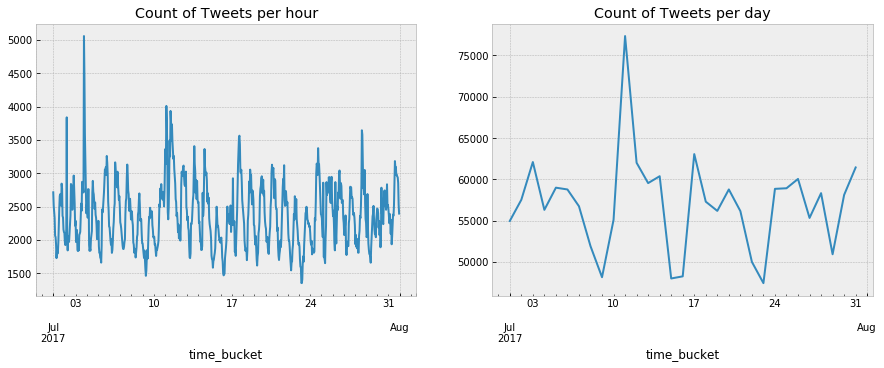

In [37]:
# use the same "_rule" string
print("Recall, our rule is: {}".format(_rule_b))
count_rule_b = gen_rule_payload(_rule_b,
                        from_date="2017-07-01",
                        to_date="2017-08-01",
                        count_bucket="hour")

counts_list = collect_results(count_rule_b, max_results=24*31, result_stream_args=search_args)

# plot a timeseries of the Tweet counts
tweet_counts = (pd.DataFrame(counts_list)
                .assign(time_bucket = lambda x: pd.to_datetime(x["timePeriod"]))
                .drop("timePeriod",axis = 1)
                .set_index("time_bucket")
                .sort_index())

fig, axes = plt.subplots(nrows=1, ncols=2, figsize = (15,5))
(tweet_counts
 .plot(ax=axes[0],
       title = "Count of Tweets per hour", legend = False));
(tweet_counts
 .resample("D")
 .sum()
 .plot(ax=axes[1],
       title="Count of Tweets per day",
       legend=False));

## Look at that regular timeseries!

Remember when we noted that the Tweet timeseries around flying is unlikely to have big, irregular spikes? It seems like we got rid of most of them, save one or two. Let's look into those last spikes and exclude those too.

In [38]:
# let's look at the highest volume day
spike_rule_711 = gen_rule_payload(_rule_b,
                                  from_date="2017-07-11",
                                  to_date="2017-07-12",
                                  ) 

# force results to evaluate (this step actually makes the API calls)
spike_results_list_711 = collect_results(spike_rule_711, max_results=500, result_stream_args=search_args)

In [39]:
get_frequent_terms([x.all_text for x in spike_results_list_711],
                   stop_words="english",
                   ngram_range = (1,1)).head(15)

,count
token,
plane,244
airport,195
crash,62
landed,48
mississippi,42
marine,39
international,38
i'm,37
killed,35


## Frequent terms vs frequent "n-grams"

We've talked about using frequent terms to identify what a corpus of Tweets is about, but I want to mention frequent "n-grams" as a slightly more sophisticated alternative.

**n-gram**: a sequence of *n* tokens from a document

Using frequent n-grams, you might be able to identify when words show together, in the same sequence surprisingly often - potentially indicating spam, promotional material, memes, lyrics, or reposted content. Pay attention to words that appear together, and you can exclude an n-gram by excluding an "exact phrase" from your Search query.

In [40]:
# let's look at 2- and 3- grams
get_frequent_terms([x.all_text for x in spike_results_list_711],
                   stop_words = "english",
                   ngram_range = (2,3)).head(20)

,count
token,
plane crash,58
international airport,37
mississippi plane,30
mississippi plane crash,30
killed mississippi,29
marine vermont killed,29
marine vermont,29
vermont killed,29
vermont killed mississippi,29


In this data, we can see that `"mississippi plane crash"`, `"killed mississippi plane	"`, "vermont killed mississippi" all show up frequently, and they all show up *the same number of times*. Let me find one of those Tweets to look at:

In [41]:
[x.all_text for x in spike_results_list_711 if "vermont" in x.all_text.lower()][0:5]

['Marine from Vermont killed in Mississippi plane\xa0crash https://t.co/RGnRfCI0lg',
 'KMBC  @kmbc\n Marine from Vermont killed in Mississippi plane crash https://t.co/DirY01X2Pd https://t.co/QTaRr1JkNQ',
 'Pittsburgh News Marine from Vermont killed in Mississippi plane crash https://t.co/dk71SLzkm5 https://t.co/JfgXcdO1yR',
 'Marine from Vermont killed in Mississippi plane crash https://t.co/HvjlG7vp6W https://t.co/Ij4MCBBFQn',
 'Marine from Vermont killed in Mississippi plane crash https://t.co/7hSTiZxMmX https://t.co/irB0fdy6Vs']

Doesn't have much to do with the experience of flying in a plane. Let's exclude it. In this case, we might exclude these Tweets pretty precisely by excluding "Marine" (it's good to pick specific, unambiguous terms for exclusions, so that you don't do anything too broad), but for this example we'll exclude "plane crash"--it's precise enough, will exclude other similar news-type content, and we can demonstrate exact phrase matching.

Add this to my rule: `-"plane crash"`

In [42]:
# expand based on what you see
_rule_c = """
(plane OR landed OR airport OR takeoff OR #wheelsup)
-is:retweet
-trump
-harry
-drowned
-g20
-lawyer
-gimpo
-fuck
-"plane crash"
"""

spike_rule_704 = gen_rule_payload(_rule_c,
                                  from_date="2017-07-04",
                                  to_date="2017-07-05",
                                  )

spike_results_list_704 = collect_results(spike_rule_704, max_results=500, result_stream_args=search_args)

In [43]:
get_frequent_terms([x.all_text for x in spike_results_list_704], stop_words = "english", ngram_range = (2,3)).head(20)

,count
token,
hampton airport,39
citizens east hampton,39
east hampton,39
east hampton airport,39
citizens east,39
international airport,30
airport james,29
hampton airport james,29
james barron,29


Now, it's not the top term, but when a specific hashtag shows up with some frequency, it's time take a look. Hashtags are often used to group together topics, and by filtering the hashtag we could catch irrelevant topics. Let's look at "#gameinsight."

In [44]:
# try searching on the hashtag:
[x.all_text for x in spike_results_list_704 if "gameinsight" in x.hashtags][0:5]

['¡He completado la misión Día Desafortunado en el juego Airport-City! https://t.co/Ya2oVyXXHo #android #gameinsight',
 '¡He alcanzado el nivel 8 en el juego Airport-City! https://t.co/Ya2oVyXXHo #android #gameinsight',
 'New plane in my Airport City: Turboprop! https://t.co/Ky4J5dMyBT #iOS #gameinsight',
 "I've completed Party Like You Mean It quest in Airport City! https://t.co/QaJ1PIehi7 #android #gameinsight",
 "I've completed A Chinese Torture quest in Airport City! https://t.co/QaJ1PIehi7 #android #gameinsight"]

Well, that looks like spam. Let's exclude a hashtag this time: it's specific, seems to appear in this content, and easy to exclude. Use the hashtag and negation operator in Search like this:

Add `-#gameinsight`

Also, it's not clear that "gameinsight" is all of this spike. Try searching for "hampton" too (as it is one of the most common terms):

In [45]:
[x.all_text for x in spike_results_list_704 if "hampton" in x.all_text.lower()][0:5]

['The Citizens of East Hampton v. Its Airport https://t.co/xDRiyor0Ej',
 '"The Citizens of East Hampton v. Its Airport" https://t.co/Fm6NOXqRen',
 '"The Citizens of East Hampton v. Its Airport" by JAMES BARRON via NYT https://t.co/LAMg6kHkZN https://t.co/pHhMKTw8Kx',
 '#3Novices : The Citizens of East Hampton v. Its Airport The Supreme Court’s refusal last week to review local restrictions on flights is th…',
 '"The Citizens of East Hampton v. Its Airport" by JAMES BARRON via NYT https://t.co/eaW8rdnj4M']

Now,  could add: `-"citizens of east hampton"` and exclude this one news story, but we might have identified a larger pattern.

__URL matching__  

News stories about planes, crashes, etc are showing up a lot, and we do not  want to see any of them in the final dataset (again, this is absolutely a choice, and it will eliminate a lot of data, for better or for worse). We're going to choose to exclude all Tweets with certain big news URLs included in them. We're not going to get this perfect here, but we will see how to use the URL matching rule, and give you more ideas about how to filter Tweets.

The `url:<token>` operator performs a tokenized match on words in the unrolled URL that was posted in the Tweet. We'll eliminate Tweets with: "nytimes","bbc","washingtonpost", "cbsnews", "reuters", "apnews", and "news" in the URL.

Add:
`-url:nytimes -url:bbc -url:washingtonpost -url:cbsnews -url:reuters -url:apnews -url:news`

In [46]:
# expand based on what you see
_rule_d = """
(plane OR landed OR airport OR takeoff OR #wheelsup)
-is:retweet
-trump
-harry
-drowned
-g20
-lawyer
-gimpo
-fuck
-"plane crash"
-"citizens of east hampton"
-url:nytimes -url:bbc -url:washingtonpost -url:cbsnews -url:reuters -url:apnews -url:news
"""

In [47]:
# finally, let's look at that high volume hour on July 3rd
tweet_counts.sort_values(by = "count", ascending = False).head(2)

,count
time_bucket,
2017-07-03 18:00:00,5058
2017-07-03 19:00:00,4458


In [48]:
spike_rule_703 = gen_rule_payload(_rule_d, #<-remember, same rule
                                  from_date="2017-07-03T18:00",
                                  to_date="2017-07-03T19:01",
                                  )

# force results to evaluate (this step actually makes the API calls)
spike_results_list_703 = collect_results(spike_rule_703, max_results=500, result_stream_args=search_args)

In [49]:
get_frequent_terms([x.all_text for x in spike_results_list_703], stop_words = "english", ngram_range = (2,3)).head(20)

,count
token,
boston airport,133
near boston,84
near boston airport,77
logan airport,69
pedestrians near,57
airport injured,52
vehicle near boston,52
vehicle near,52
pedestrians struck,50


In [50]:
# read some Tweets
[x.all_text for x in spike_results_list_703 if "Boston" in x.all_text][0:10]

['#gossip Car Strikes Crowd at East Boston Airport, Multiple People Injured https://t.co/lK1EIbm9OJ',
 'Tru Town Films Car Strikes Crowd at East Boston Airport, Multiple People Injured https://t.co/eUy8dWqXuD',
 'Car Strikes Crowd at East Boston Airport, Multiple People Injured https://t.co/4YcPZ3QkZA',
 'Car Strikes Crowd at East Boston Airport, Multiple People\xa0Injured https://t.co/yyijNbPa4p',
 'Pedestrians struck by vehicle near Boston airport, several injuries reported https://t.co/yOnQ9bGWBk #p2 #ctl https://t.co/ugVOtnwzLs\n\n— …',
 "The Times Picayune - Vehicle hits pedestrians near Boston's Logan Airport: report https://t.co/BpDCYg2i5R",
 'Police: Boston airport crash injures 10 pedestrians https://t.co/YlGlcHFd8u',
 'Update: Taxi incident near Boston airport being treated as accident, not terrorism, law enforcement sources say https://t.co/kgvXLkd4Zk',
 'Car Strikes Crowd at East Boston Airport, Multiple People Injured https://t.co/PfJ7xhgPLT',
 'Taxi strikes pedestrians ne

We don't want to eliminate all mentions of "Boston Airport" (because many of those mentions are likely relevant to my study). Instead, we'll eliminate a few common phrases like "pedestrians struck", "pedestrians injured", "car strikes", "taxi strikes".

Add: `-"pedestrians struck" -"pedestrians injured" -"car strikes" -"taxi strikes" -"car hits"`

In [51]:
# expand based on what you see
_rule_e = """
(plane OR landed OR airport OR takeoff OR #wheelsup)
-is:retweet
-trump
-harry
-drowned
-g20
-lawyer
-gimpo
-fuck
-"plane crash"
-#gameinsight
-"citizens of east hampton"
-url:nytimes -url:bbc -url:washingtonpost -url:cbsnews -url:reuters -url:apnews -url:news
-"pedestrians struck" -"pedestrians injured" -"car strikes" -"taxi strikes" -"car hits"
"""

rule_e = gen_rule_payload(_rule_e,
                        from_date="2017-07-01",
                        to_date="2017-08-01",
                        )

results_list = collect_results(rule_e, max_results=500, result_stream_args=search_args)

Recall, our new rule is: 
(plane OR landed OR airport OR takeoff OR #wheelsup)
-is:retweet
-trump
-harry
-drowned
-g20
-lawyer
-gimpo
-fuck
-"plane crash"
-#gameinsight
-"citizens of east hampton"
-url:nytimes -url:bbc -url:washingtonpost -url:cbsnews -url:reuters -url:apnews -url:news
-"pedestrians struck" -"pedestrians injured" -"car strikes" -"taxi strikes" -"car hits"



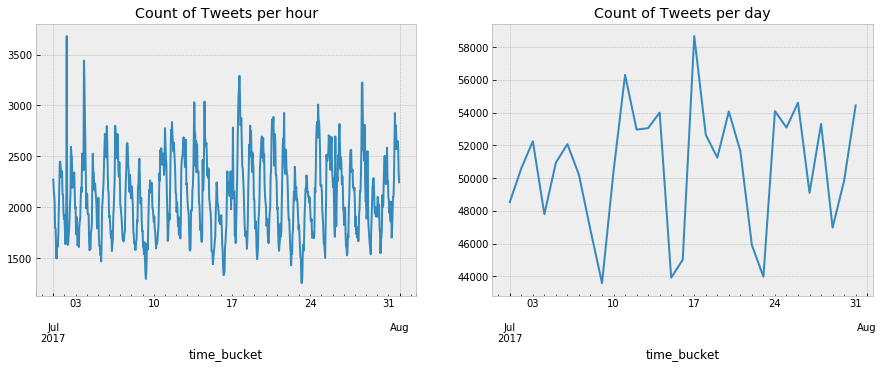

In [52]:
print("Recall, our new rule is: {}".format(_rule_e))
count_rule_e = gen_rule_payload(_rule_e,
                        from_date="2017-07-01",
                        to_date="2017-08-01",
                        count_bucket="hour")

counts_list = collect_results(count_rule_e, max_results=24*31, result_stream_args=search_args)

# plot a timeseries of the Tweet counts
tweet_counts = (pd.DataFrame(counts_list)
     .assign(time_bucket = lambda x: pd.to_datetime(x["timePeriod"]))
     .drop("timePeriod",axis = 1)
     .set_index("time_bucket")
     .sort_index()
)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize = (15,5))
_ = tweet_counts.plot(ax=axes[0], title = "Count of Tweets per hour", legend = False)
_ = tweet_counts.resample("D").sum().plot(ax=axes[1], title = "Count of Tweets per day", legend = False)

## Look how much irrelevant data we've eliminated

Let's compare the volume of our first (unrefined) rule to our most recent one.

Spoiler: We've eliminated a huge amount of unhelpful data!

Now you can begin to think about using this data in an analysis.

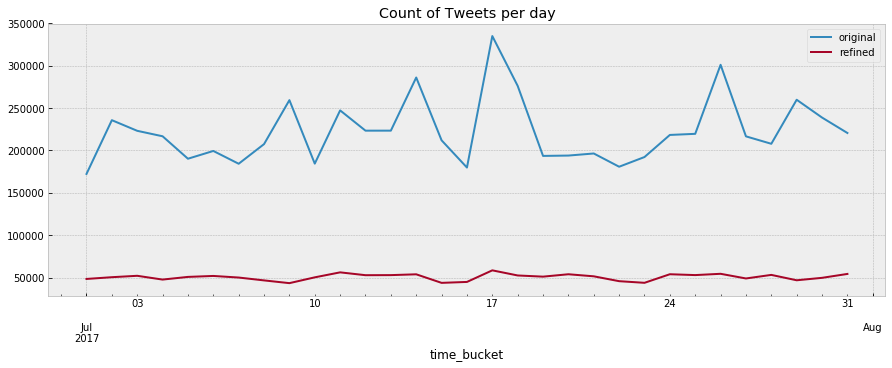

In [53]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize = (15,5))
tweet_counts_original.resample("D").sum().plot(ax=axes, title = "Count of Tweets per day", legend = False)
tweet_counts.resample("D").sum().plot(ax=axes, title = "Count of Tweets per day", legend = False)
plt.legend(["original", "refined"]);

In [54]:
get_frequent_terms([x.all_text for x in results_list], stop_words = "english", ngram_range = (1,2)).head(20)

,count
token,
airport,247
plane,173
landed,64
i'm,36
just,35
international,32
international airport,30
people,21
like,21


## Pulling our dataset

It's always possible to continue refining a dataset, and we should definitely continue that work after pulling the Tweets. The key in early data-cleaning steps is to eliminate a large bulk of irrelevant Tweets that you don't want to store or pay for (we did that).

Now (**warning!** this will use quite a few API calls and you might want to think twice before actually running it. The cell type is markdown so you can't run it on accident) let's pull data with our final rule.

Before you decide to pull this data, we'll check how many API calls we've used in this notebook (the `ResultStream` object provides a convenience variable for this).

In [55]:
# count API calls
print("You have used {} API calls in this session".format(ResultStream.session_request_counter))

You have used 12 API calls in this session


__Store the data you pull!__  

You don't want to pull this much data without saving it for later. We're going to use the `ResultStream` object to make API calls, stream data in an iterator, hold relevant data information in memory in my Python session, and (importantly!) stream raw Tweets to a file for later use.

Even if you don't want to run these exact API calls, pay attention to how this is done for your own work.

__Finalize your rule__  

In [56]:
# this is our final rule
print(_rule_e)


(plane OR landed OR airport OR takeoff OR #wheelsup)
-is:retweet
-trump
-harry
-drowned
-g20
-lawyer
-gimpo
-fuck
-"plane crash"
-#gameinsight
-"citizens of east hampton"
-url:nytimes -url:bbc -url:washingtonpost -url:cbsnews -url:reuters -url:apnews -url:news
-"pedestrians struck" -"pedestrians injured" -"car strikes" -"taxi strikes" -"car hits"



__No surprises__  
You should always have a guess at how many Tweets you're going to pull _before_ you pull them. Use the Counts API (if possible), or extrapolate based on a smaller time period of data.

In [57]:
# I can sum up the counts endpoint results to guess how may Tweets I'll get 
# (or, if you don't have access to the counts endpoints, try extrapolating from a single day)
tweet_counts.sum()

count    1572126
dtype: int64

__Narrowing your dataset further__  

You might refine your rule and find that there are still millions of Tweets about a topic on Twitter (this happens, there are lots of Tweets). 

If your rule is still going to pull an unrealistic number of Tweets, maybe narrow the scope of your investigation. You can:
- **Narrow the time period**: do you really need a month of data? or maybe you could sample just a few days?
- **Select more specific Tweets**: maybe it would be helpful to your analysis to have only Tweets that are geo tagged (this reduces data volume significantly)? Or only pull Tweets from users with profile locations? Putting stringent requirements on data can help speed up your analysis and make your data volume smaller.
- **Sampling**: Search API doesn't support random sampling the way that the Historical APIs do. You'll have to come up with balanced ways of selecting for less data, or you can sample based on geography, time, Tweet language--anything to narrow your scope.

I'm going to show one example of this by *only* pulling Tweets from users with a profile location (you can read up more on what a "profile location" means in our documentation) in the state of Colorado (this is for illustrative purposes, depending on your use case, we'd probably recommend narrowing the time scope first).

Add: `profile_country:US profile_region:Colorado` to my Twitter Search rule.

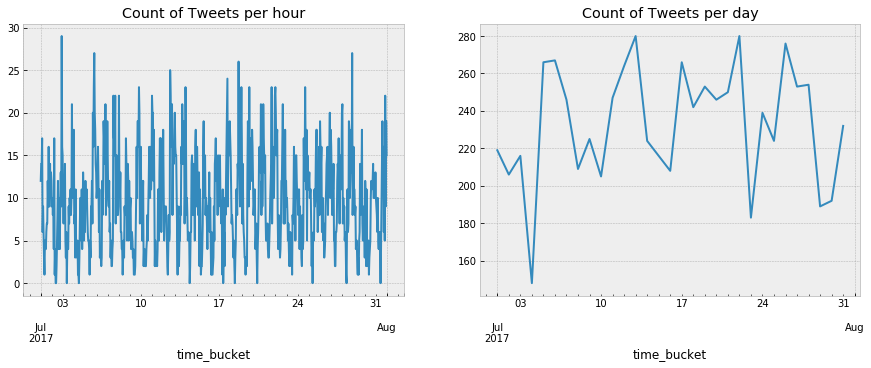

In [58]:
final_rule = """
(plane OR landed OR airport OR takeoff OR #wheelsup)
-is:retweet
-trump
-harry
-drowned
-g20
-lawyer
-gimpo
-fuck
-"plane crash"
-#gameinsight
-"citizens of east hampton"
-url:nytimes -url:bbc -url:washingtonpost -url:cbsnews -url:reuters -url:apnews -url:news
-"pedestrians struck" -"pedstrians injured" -"car strikes" -"taxi strikes" -"car hits"
profile_country:US profile_region:"Colorado"
"""

count_rule = gen_rule_payload(final_rule,
                        from_date="2017-07-01",
                        to_date="2017-08-01",
                        count_bucket="hour")

counts_list = collect_results(count_rule, max_results=24*31, result_stream_args=search_args)

# plot a timeseries of the Tweet counts
tweet_counts = (pd.DataFrame(counts_list)
     .assign(time_bucket = lambda x: pd.to_datetime(x["timePeriod"]))
     .drop("timePeriod",axis = 1)
     .set_index("time_bucket")
     .sort_index()
)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize = (15,5))
_ = tweet_counts.plot(ax=axes[0], title = "Count of Tweets per hour", legend = False)
_ = tweet_counts.resample("D").sum().plot(ax=axes[1], title = "Count of Tweets per day", legend = False)

In [59]:
tweet_counts.sum()

count    7225
dtype: int64

## Save Tweets to a file, and stream them into memory 


Seems like a reasonable number of Tweets. Let's go get them.

This time, we're going to use the ResultStream object and stream the full Tweet payloads to a file while simultaneously creating a Pandas DataFrame in memory of the limited Tweet fields that we care about. 

If you actually want to run the cell below, you'll have to set the cell type to "code."

```python
final_rule_payload = gen_rule_payload(final_rule,
                                      from_date="2017-07-01",
                                      to_date="2017-08-01")

stream = ResultStream(**search_args,
                       rule_payload=final_rule_payload,
                       max_results=None) # should collect all of the results

# write_ndjson is a utility function that writes the results to a file and passes them through the iterator
from searchtweets.utils import write_ndjson

limited_fields = []
for x in write_ndjson("air_travel_data.json", stream.stream()):
    limited_fields.append({"date": x.created_at_datetime,
                           "text": x.all_text,
                           "user": x.screen_name,
                           "bio": x.bio,
                           "at_mentions": [u["screen_name"] for u in x.user_mentions],
                           "hashtags": x.hashtags,
                           "urls": x.most_unrolled_urls,
                           "geo": x.geo_coordinates,
                           "type": x.tweet_type,
                           "id": x.id})
# create a dataframe
final_dataset_df = pd.DataFrame(limited_fields)
final_dataset_df.head()
```

# Conclusion

All Tweet data collection should be focused on a question, and our focused on finding out what people were talking about while they flew on airplanes. You can use the same basic steps that we used here to answer your own business questions using Twitter data.

1. Consume Tweet data 
    - We walked through how to access the Search API using the `searchtweets` [package](https://github.com/twitterdev/search-tweets-python) and how to write rules to get the Tweets that you are looking for.
2. Parse Twitter data
    - We talked about the JSON Tweet payloads, `Tweet` objects (provided by the `tweet_parser` [package](https://github.com/twitterdev/tweet_parser)), and Tweet [payload elements](https://developer.twitter.com/en/docs/tweets/data-dictionary/overview/intro-to-tweet-json).
3. Describe Twitter data
     - We talked about how to describe data, using frequent terms, top users, timeseries spikes, and Twitter elements like hashtags and links. 
4. Iterate on your search terms to filter the data
    - We talked about how to narrow down a search by negating irrelevant terms, narrowing the time or the area of your search, and iterating until you retrieve a reasonable number of Tweets.